In [ ]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, accuracy_score
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class
class WoundDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.annotation_file = annotation_file
        self.transform = transform
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        
        # Extract image IDs and file names
        self.image_info = {img['id']: img['file_name'] for img in self.annotations['images']}
        self.image_id_to_annotation = {ann['image_id']: ann for ann in self.annotations['annotations']}
    
    def __len__(self):
        return len(self.annotations['images'])
    
    def __getitem__(self, idx):
        image_id = self.annotations['images'][idx]['id']
        file_name = self.image_info[image_id]
        image_path = os.path.join(self.image_dir, file_name)
        
        # Load image and resize to a fixed size
        image = Image.open(image_path).convert("RGB")
        image = image.resize((224, 224), Image.Resampling.BILINEAR)
        
        # Load segmentation mask from JSON
        ann = self.image_id_to_annotation.get(image_id, None)
        if ann:
            segmentation = ann['segmentation'][0]
            mask = self.polygon_to_mask(segmentation, image.width, image.height)
        else:
            mask = np.zeros((image.height, image.width))
        # Convert mask to tensor and resize to match the image dimensions
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))  # Scale to 0-255 for PIL
        mask_img = mask_img.resize((224, 224), Image.Resampling.NEAREST)
        mask = transforms.ToTensor()(mask_img).float()  # Convert to tensor and scale back to 0-1
        mask = torch.nn.functional.interpolate(mask.unsqueeze(0), size=(224, 224), mode='nearest').squeeze(0)
        
        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)
            mask = torch.nn.functional.interpolate(mask.unsqueeze(0), size=(224, 224), mode='nearest').squeeze(0)
        
        # Also return the original image without any transformations
        # Convert PIL image to numpy array for the original image
        original_image = np.array(image)
        original_image = np.array(image)
        return image, mask, original_image
    
    def polygon_to_mask(self, polygon, width, height):
        from PIL import Image, ImageDraw
        img = Image.new('L', (width, height), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        mask = np.array(img).astype(np.float32)
        return mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Initialize dataset and dataloader
dataset_base_path = '/home/abdulkader/Desktop/Datasets/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients'
annotation_file = os.path.join(dataset_base_path, 'annotations', 'annotations.json')

dataset = WoundDataset(
    image_dir=os.path.join(dataset_base_path, 'imgs'),
    annotation_file=annotation_file,
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize U-Net model
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
)

model = model.to(device)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

loss_fn = torch.nn.BCELoss()

# Track training and validation loss for the learning curve
train_losses = []
val_losses = []

# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, masks, _) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")
    
    avg_train_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Average Training Loss: {avg_train_loss}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, masks, _) in enumerate(val_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1} Average Validation Loss: {avg_val_loss}")

    # Step the scheduler
    scheduler.step(avg_val_loss)
    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    
    # Track training loss
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch {epoch+1} Average Training Loss: {avg_train_loss}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, masks, _) in enumerate(val_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} Average Validation Loss: {avg_val_loss}")

    # Debugging: Check model's output on a sample batch
    if epoch % 10 == 0:
        with torch.no_grad():
            sample_images = images[:2]  # Take first 2 images from the batch
            sample_outputs = model(sample_images)
            print(f"Sample outputs (before thresholding): {sample_outputs.flatten()[:10]}")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    iou_scores = []
    dice_scores = []
    accuracy_scores = []
    
    with torch.no_grad():
        for images, masks, _ in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predicted_masks = (outputs > 0.5).float()
            
            # Convert to numpy arrays and ensure binary values
            masks_np = (masks.cpu().numpy().flatten() > 0.5).astype(np.int32)
            predicted_masks_np = (predicted_masks.cpu().numpy().flatten() > 0.5).astype(np.int32)
            
            # Calculate metrics
            iou = jaccard_score(masks_np, predicted_masks_np, average='binary')
            dice = 2 * np.sum(masks_np * predicted_masks_np) / (np.sum(masks_np) + np.sum(predicted_masks_np) + 1e-6)
            accuracy = accuracy_score(masks_np, predicted_masks_np)
            
            iou_scores.append(iou)
            dice_scores.append(dice)
            accuracy_scores.append(accuracy)
    
    return np.mean(iou_scores), np.mean(dice_scores), np.mean(accuracy_scores)

# Evaluate the model
iou, dice, accuracy = evaluate_model(model, val_dataloader, device)
print(f"Validation IoU: {iou}, Dice: {dice}, Accuracy: {accuracy}")

# Visualization function
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 5, figsize=(25, 5 * num_samples))
    
    # Define a fixed size for visualization
    vis_size = (224, 224)
    
    with torch.no_grad():
        for i, (images, masks, original_images) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            images = images.to(device)
            masks = masks.cpu().numpy()
            
            # Process one image at a time
            for j in range(min(num_samples, len(original_images))):
                if j >= images.size(0):
                    break
                    
                # Convert numpy array to PIL Image
                pil_img = Image.fromarray(original_images[j].astype('uint8'))
                # Resize the image
                resized = pil_img.resize(vis_size, Image.Resampling.BILINEAR)
                # Convert back to numpy array
                resized_img = np.array(resized)
                
                # Plot images, ground truth masks, predicted masks, and overlays
                # Original Image
            if len(original_images) == 0:
                print("No images to visualize")
                return
            
            outputs = model(images)
            predicted_masks = (outputs > 0.5).float().cpu().numpy()
            axes[j, 0].set_title("Original Image")
            axes[j, 0].axis('off')
                
                # Ground Truth Mask
            axes[j, 1].imshow(masks[j][0], cmap='gray')
            axes[j, 1].set_title("Ground Truth Mask")
            axes[j, 1].axis('off')
                
                # Predicted Mask
            axes[j, 2].imshow(predicted_masks[j][0], cmap='gray')
            axes[j, 2].set_title("Predicted Mask")
            axes[j, 2].axis('off')
                
                # Overlay Ground Truth Mask on Original Image
            overlay_gt = original_images[j].copy()
            overlay_gt[:, :, 1] += (masks[j][0].cpu().numpy() * 255).astype(np.uint8)  # Scale to 0-255 and cast to uint8
            overlay_gt = np.clip(overlay_gt, 0, 255)
            axes[j, 3].imshow(overlay_gt)
            axes[j, 3].set_title("Overlay with Ground Truth")
            axes[j, 3].axis('off')
            
            # Overlay Predicted Mask on Original Image
            overlay_pred = original_images[j].copy()
            overlay_pred[:, :, 1] += (predicted_masks[j][0] * 255).astype(np.uint8)  # Scale to 0-255 and cast to uint8
            overlay_pred = np.clip(overlay_pred, 0, 255)
            axes[j, 4].imshow(overlay_pred)
            axes[j, 4].set_title("Overlay with Prediction")
            axes[j, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dataloader, device)

Epoch 1, Batch 1, Loss: 1.0865836143493652
Epoch 1, Batch 2, Loss: 1.0738658905029297
Epoch 1, Batch 3, Loss: 1.035048484802246
Epoch 1, Batch 4, Loss: 1.0294911861419678
Epoch 1, Batch 5, Loss: 1.0173046588897705
Epoch 1, Batch 6, Loss: 0.9645615816116333
Epoch 1, Batch 7, Loss: 1.0213086605072021
Epoch 1, Batch 8, Loss: 0.8593276739120483
Epoch 1, Batch 9, Loss: 0.9807350635528564
Epoch 1, Batch 10, Loss: 0.9518932104110718
Epoch 1, Batch 11, Loss: 0.8948035836219788
Epoch 1, Batch 12, Loss: 0.9298739433288574
Epoch 1, Batch 13, Loss: 0.8894445896148682
Epoch 1, Batch 14, Loss: 0.8737608194351196
Epoch 1, Batch 15, Loss: 0.7692859768867493
Epoch 1, Batch 16, Loss: 0.841424286365509
Epoch 1, Batch 17, Loss: 0.7826039791107178
Epoch 1, Batch 18, Loss: 0.7927969694137573
Epoch 1, Batch 19, Loss: 0.8304119110107422
Epoch 1, Batch 20, Loss: 0.7462298274040222
Epoch 1, Batch 21, Loss: 0.7898720502853394
Epoch 1, Batch 22, Loss: 0.8628852963447571
Epoch 1, Batch 23, Loss: 0.752590537071228


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.60514

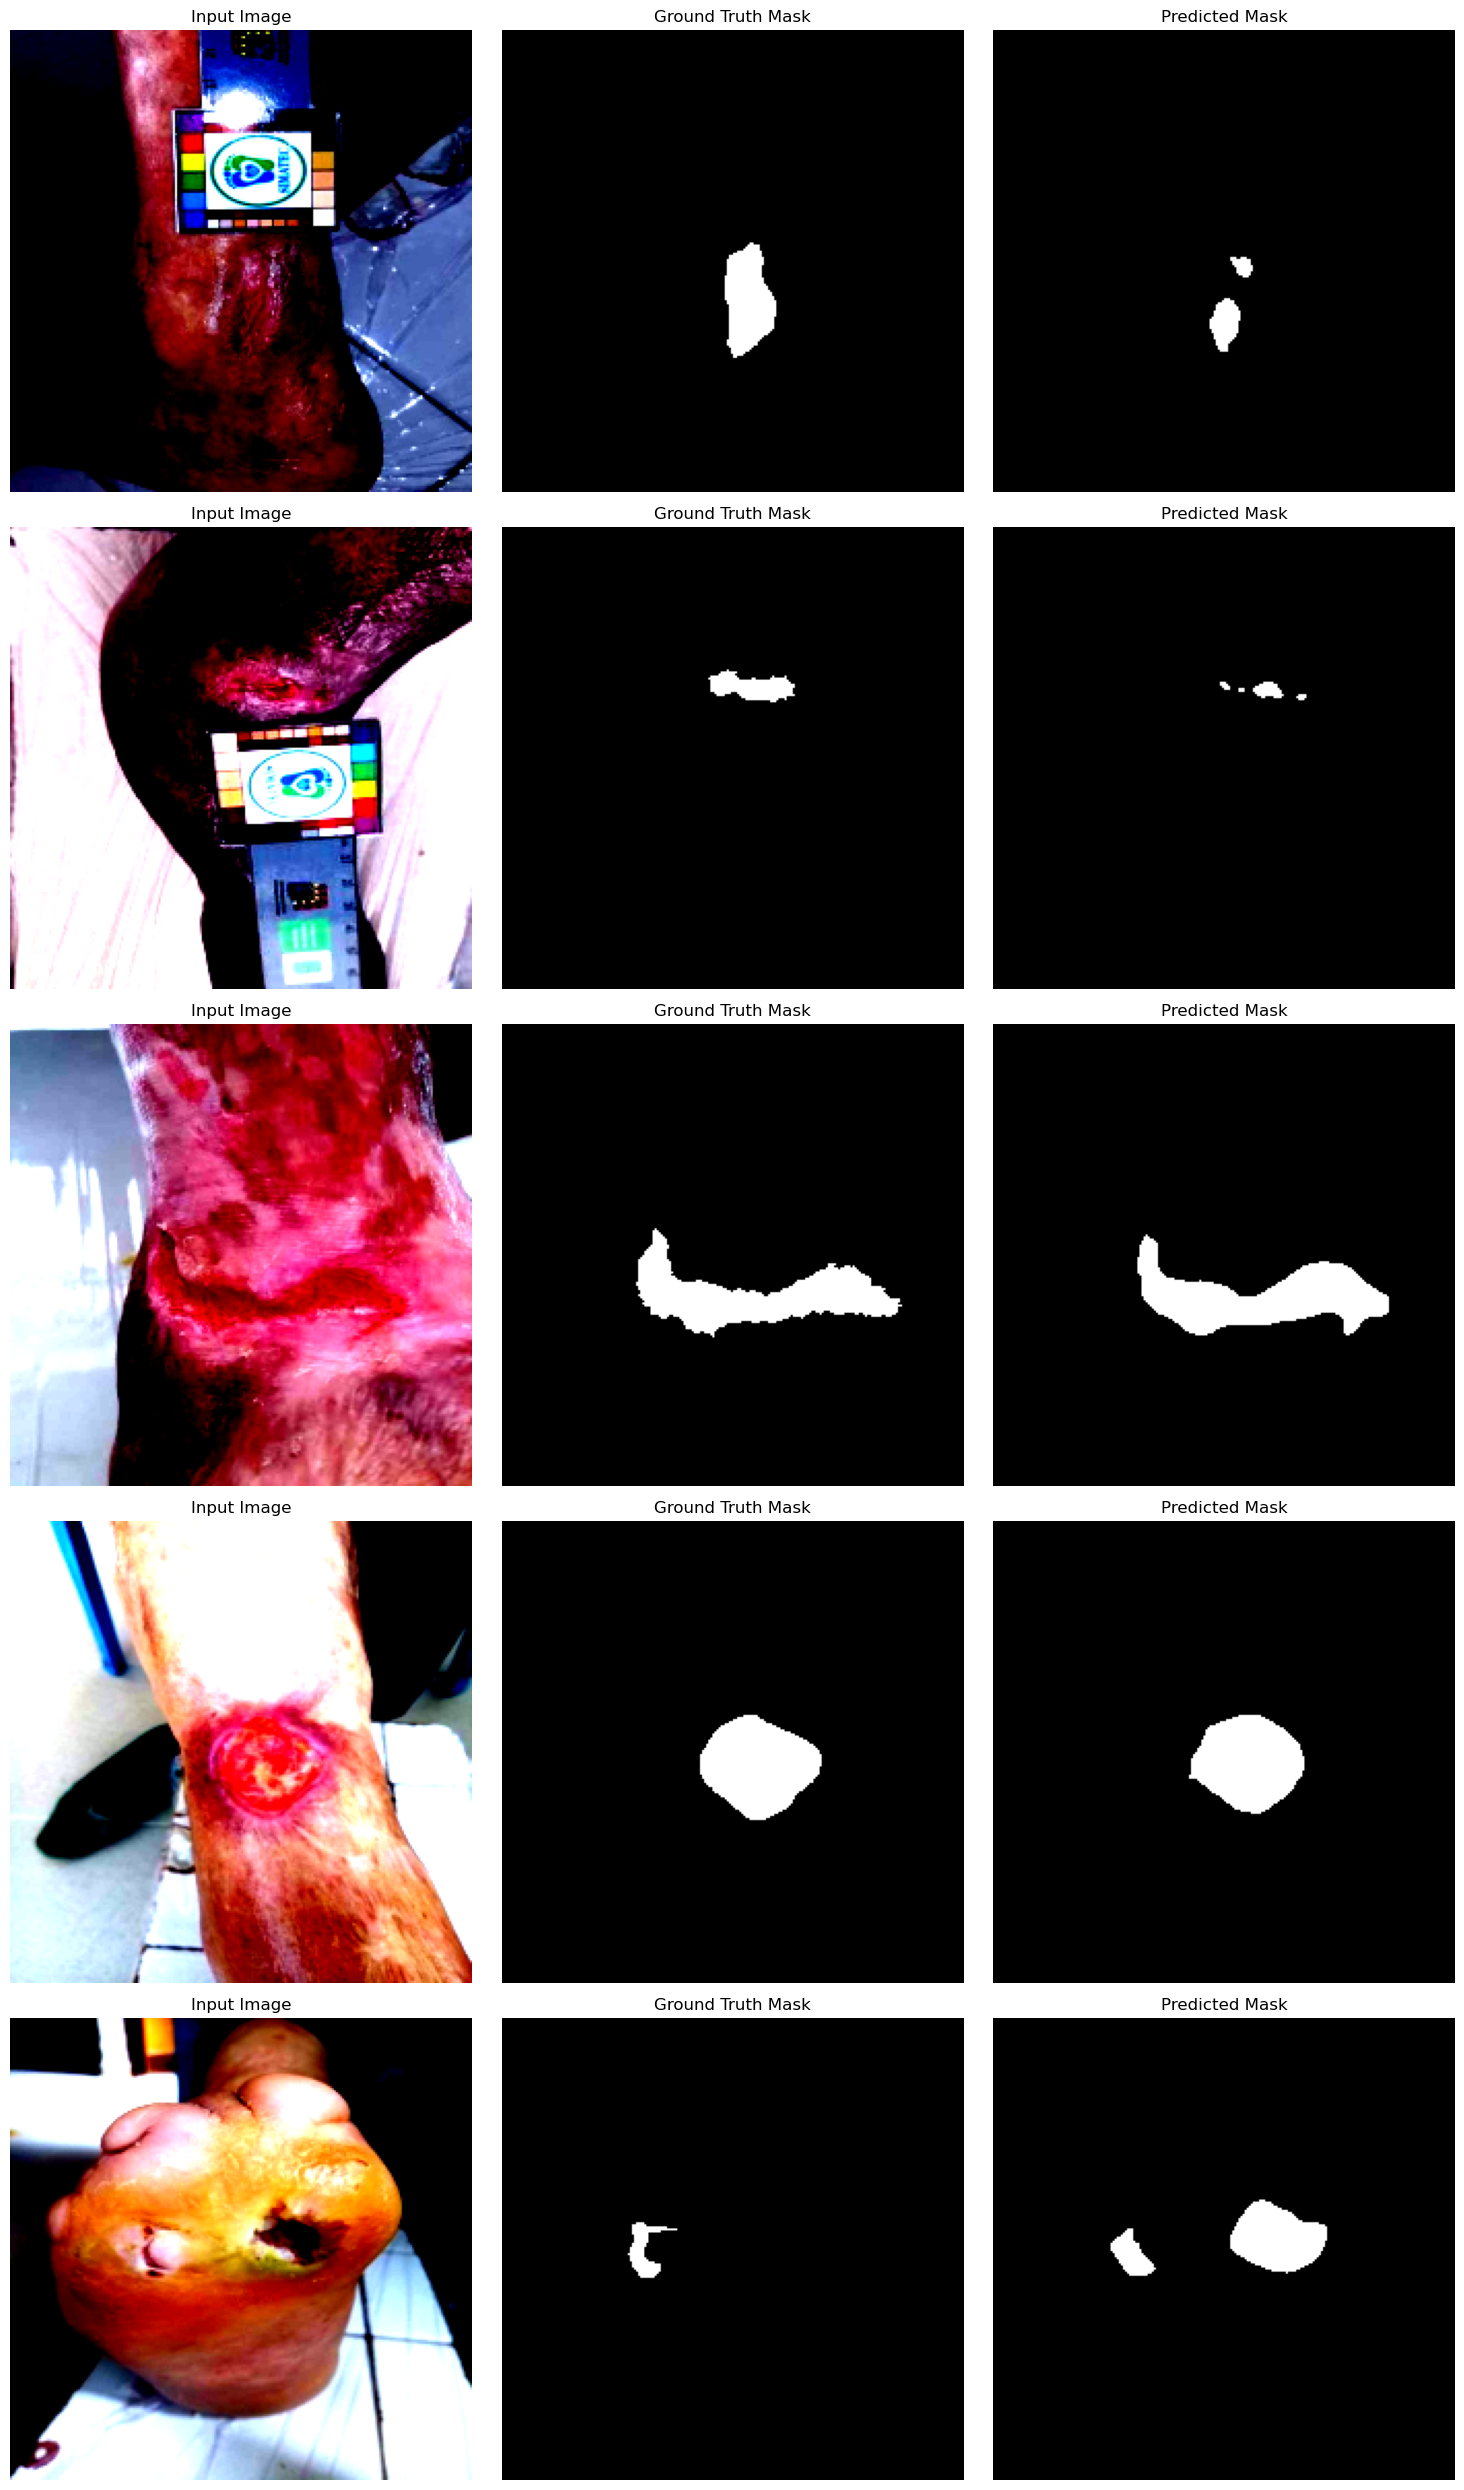

In [2]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class
class WoundDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.annotation_file = annotation_file
        self.transform = transform
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        
        # Extract image IDs and file names
        self.image_info = {img['id']: img['file_name'] for img in self.annotations['images']}
        self.image_id_to_annotation = {ann['image_id']: ann for ann in self.annotations['annotations']}
    
    def __len__(self):
        return len(self.annotations['images'])
    
    def __getitem__(self, idx):
        image_id = self.annotations['images'][idx]['id']
        file_name = self.image_info[image_id]
        image_path = os.path.join(self.image_dir, file_name)
        
        # Load image
        image = Image.open(image_path).convert("RGB")
        
        # Load segmentation mask from JSON
        ann = self.image_id_to_annotation.get(image_id, None)
        if ann:
            segmentation = ann['segmentation'][0]
            mask = self.polygon_to_mask(segmentation, image.width, image.height)
        else:
            mask = np.zeros((image.height, image.width))
        
        # Convert mask to tensor and apply transformations
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))  # Scale to 0-255 for PIL
        if self.transform:
            image = self.transform(image)
            # Apply same resize to mask
            mask_img = transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)(mask_img)
            mask = transforms.ToTensor()(mask_img).float()  # Convert to tensor and scale back to 0-1
        else:
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return image, mask
    
    def polygon_to_mask(self, polygon, width, height):
        from PIL import Image, ImageDraw
        img = Image.new('L', (width, height), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        mask = np.array(img).astype(np.float32)
        return mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset and dataloader
dataset_base_path = '/home/abdulkader/Desktop/Datasets/CO2Wounds-V2 Extended Chronic Wounds Dataset From Leprosy Patients'
dataset = WoundDataset(
    image_dir=os.path.join(dataset_base_path, 'imgs'),
    annotation_file=os.path.join(dataset_base_path, 'annotations', 'annotations.json'),
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize U-Net model
model = smp.Unet(
    encoder_name="resnet34",  # You can try other encoders like "resnet50", "se_resnext50_32x4d", etc.
    in_channels=3,
    classes=1,
    activation="sigmoid"
)
# import segmentation_models_pytorch as smp

# # Initialize SegFormer model which is better suited for Vision Transformer-based segmentation
# model = smp.UnetPlusPlus(
#     encoder_name="efficientnet-b0",  # Using EfficientNet as encoder
#     encoder_weights="imagenet",      # Using pretrained weights
#     in_channels=3,
#     classes=1,
#     activation="sigmoid"
# )

model = model.to(device)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = torch.nn.BCELoss()

# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")
    
    print(f"Epoch {epoch+1} Average Loss: {epoch_loss / len(train_dataloader)}")

    # Debugging: Check model's output on a sample batch
    if epoch % 10 == 0:
        with torch.no_grad():
            sample_images = images[:2]  # Take first 2 images from the batch
            sample_outputs = model(sample_images)
            print(f"Sample outputs (before thresholding): {sample_outputs.flatten()[:10]}")

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    iou_scores = []
    dice_scores = []
    accuracy_scores = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predicted_masks = (outputs > 0.5).float()
            
            # Convert to numpy arrays and ensure binary values
            masks_np = (masks.cpu().numpy().flatten() > 0.5).astype(np.int32)
            predicted_masks_np = (predicted_masks.cpu().numpy().flatten() > 0.5).astype(np.int32)
            
            # Calculate metrics
            iou = jaccard_score(masks_np, predicted_masks_np, average='binary')
            dice = 2 * np.sum(masks_np * predicted_masks_np) / (np.sum(masks_np) + np.sum(predicted_masks_np) + 1e-6)
            accuracy = accuracy_score(masks_np, predicted_masks_np)
            
            iou_scores.append(iou)
            dice_scores.append(dice)
            accuracy_scores.append(accuracy)
    
    return np.mean(iou_scores), np.mean(dice_scores), np.mean(accuracy_scores)

# Evaluate the model
iou, dice, accuracy = evaluate_model(model, val_dataloader, device)
print(f"Validation IoU: {iou}, Dice: {dice}, Accuracy: {accuracy}")

# Visualization function
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            images = images.to(device)
            masks = masks.cpu().numpy()
            
            outputs = model(images)
            predicted_masks = (outputs > 0.5).float().cpu().numpy()
            
            # Plot images, ground truth masks, and predicted masks
            for j in range(images.size(0)):
                axes[i, 0].imshow(images[j].permute(1, 2, 0).cpu().numpy())
                axes[i, 0].set_title("Input Image")
                axes[i, 0].axis('off')
                
                axes[i, 1].imshow(masks[j][0], cmap='gray')
                axes[i, 1].set_title("Ground Truth Mask")
                axes[i, 1].axis('off')
                
                axes[i, 2].imshow(predicted_masks[j][0], cmap='gray')
                axes[i, 2].set_title("Predicted Mask")
                axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dataloader, device)

In [ ]:
import torch
torch.cuda.empty_cache()